## Fixing the issue with losses not matching in 2 codes


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

import subprocess as sp
import sys
import os
import glob
import pickle 

from matplotlib.colors import LogNorm, PowerNorm, Normalize

import pandas as pd

import argparse
import os
import random


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# from torch.utils.data import DataLoader, TensorDataset

import time
from datetime import datetime
import glob
import pickle
import yaml

from scipy import fftpack


In [3]:
import tensorflow as tf

In [4]:
ip_fname='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/raw_data/128_square/dataset_2_smoothing_200k/norm_1_train_val.npy'
img=np.load(ip_fname)[:1000].transpose(0,1,2,3)
print(img.shape)

(1000, 1, 128, 128)


In [5]:
def f_get_azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    source: https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    """
    # Create a grid of points with x and y coordinates
    y, x = np.indices(image.shape)
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    # Get the radial coordinate for every grid point. Array has the shape of image
    r = np.hypot(x - center[0], y - center[1])

    ind = np.argsort(r.flat) ### Get indices that sort the "r" array in ascending order.

    r_sorted = r.flat[ind]     ### Sort the "r" array
    
    i_sorted = image.flat[ind]   ### Sort the image points according to the radial coordinate

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [6]:
f_get_azimuthalAverage(img[0,0,:,:])

array([-0.79014824, -0.79390586, -0.78008761, -0.77058277, -0.72040414,
       -0.70957358, -0.66486405, -0.63041123, -0.5706561 , -0.54520678,
       -0.55147036, -0.56255512, -0.59961115, -0.61376042, -0.63936411,
       -0.59064076, -0.62994025, -0.64525025, -0.63018659, -0.62314733,
       -0.65984874, -0.66041437, -0.63758972, -0.65422838, -0.67418553,
       -0.71248287, -0.72832141, -0.73619783, -0.71805094, -0.67829857,
       -0.70974613, -0.69615242, -0.69571873, -0.69538734, -0.69893509,
       -0.71637498, -0.73063947, -0.75288642, -0.7419325 , -0.73731766,
       -0.74956096, -0.75855984, -0.74304194, -0.73655171, -0.73438776,
       -0.73108071, -0.71476648, -0.71962477, -0.73006291, -0.74633861,
       -0.75474244, -0.75125576, -0.75006711, -0.73131409, -0.70210458,
       -0.66954203, -0.66606046, -0.69497293, -0.72430454, -0.74387425,
       -0.74642164, -0.72114354, -0.73102843, -0.73997375, -0.75282545,
       -0.71745669, -0.71756587, -0.75438823, -0.76098825, -0.77

In [42]:
def azimAvg_tensor(image, center=None):
    """
    Calculate the azimuthally averaged power spectrum (1D), for a batch of image tensors.
    image - The image tensor, [N,C,H,W] format
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fractional pixels).
    
    """
    batch, channel, height, width = image.shape
    # Calculate the indices from the image
    y, x = np.indices([height, width])
    y = np.tile(y, (batch, channel, 1, 1))
    x = np.tile(x, (batch, channel, 1, 1))
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = tf.argsort(tf.reshape(r, (batch, channel, -1,)))
    r_sorted = tf.gather(tf.reshape(r, (batch, channel, -1,)), ind, batch_dims=2)
    i_sorted = tf.gather(tf.reshape(image, (batch, channel, -1,)), ind, batch_dims=2)

    
    # Get the integer part of the radii (bin size = 1)
    r_int = tf.cast(r_sorted, tf.int32)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[:,:,1:] - r_int[:,:,:-1]  # Assumes all radii represented
    rind = tf.reshape(tf.where(deltar)[:,2], (batch, -1))    # location of changes in radius
    rind = tf.expand_dims(rind, axis=1)
    nr = tf.cast(rind[:,:,1:] - rind[:,:,:-1], tf.float32)        # number of radius bin

    # Cumulative sum to figure out sums for each radius bin
    
    csum = tf.cumsum(i_sorted, axis=-1)
    print(csum.shape,rind.shape,nr.shape)
    tbin = tf.gather(csum, rind[:,:,1:], batch_dims=2) - tf.gather(csum, rind[:,:,:-1], batch_dims=2)
    radial_prof = tbin / nr

    return radial_prof

In [43]:
ans_tf=azimAvg_tensor(img[:1,:,:,:])

(1, 1, 16384) (1, 1, 89) (1, 1, 88)


In [41]:
image=img[:1,:,:,:]
print(image.shape)
batch, channel, height, width = image.shape
# Calculate the indices from the image
y, x = np.indices([height, width])
y = np.tile(y, (batch, channel, 1, 1))
x = np.tile(x, (batch, channel, 1, 1))
center=[]
if not center:
    center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])
r = np.hypot(x - center[0], y - center[1])
# Get sorted radii
ind = tf.argsort(tf.reshape(r, (batch, channel, -1,)))
r_sorted = tf.gather(tf.reshape(r, (batch, channel, -1,)), ind, batch_dims=2)
i_sorted = tf.gather(tf.reshape(image, (batch, channel, -1,)), ind, batch_dims=2)
# Get the integer part of the radii (bin size = 1)
r_int = tf.cast(r_sorted, tf.int32)

# Find all pixels that fall within each radial bin.
deltar = r_int[:,:,1:] - r_int[:,:,:-1]  # Assumes all radii represented
rind = tf.reshape(tf.where(deltar)[:,2], (batch, -1))    # location of changes in radius
rind = tf.expand_dims(rind, axis=1)
nr = tf.cast(rind[:,:,1:] - rind[:,:,:-1], tf.float32)        # number of radius bin

# Cumulative sum to figure out sums for each radius bin

csum = tf.cumsum(i_sorted, axis=-1)
tbin = tf.gather(csum, rind[:,:,1:], batch_dims=2) - tf.gather(csum, rind[:,:,:-1], batch_dims=2)
radial_prof = tbin / nr

print(radial_prof.numpy())

(1, 1, 128, 128)
[[[-0.7901482  -0.7939058  -0.7800873  -0.77058274 -0.7204039
   -0.70957375 -0.6648636  -0.63041115 -0.5706558  -0.5452073
   -0.55147195 -0.5625547  -0.59961057 -0.613761   -0.6393636
   -0.5906421  -0.6299393  -0.64525074 -0.6301893  -0.6231472
   -0.6598492  -0.6604134  -0.6375889  -0.6542273  -0.6741863
   -0.71248347 -0.72832435 -0.7361968  -0.7180521  -0.6782974
   -0.7097515  -0.69615996 -0.6957218  -0.6953781  -0.6989241
   -0.71637565 -0.7306358  -0.75288665 -0.74193496 -0.7373169
   -0.74956334 -0.75856066 -0.74304026 -0.7365396  -0.73439676
   -0.7310878  -0.71477157 -0.7196271  -0.73006076 -0.7463304
   -0.75475913 -0.7512698  -0.7500603  -0.7313202  -0.7021073
   -0.6695529  -0.6660572  -0.6949694  -0.72430277 -0.74386305
   -0.74643034 -0.7211322  -0.73102295 -0.7399998  -0.75281537
   -0.7174754  -0.7175293  -0.75436455 -0.7610016  -0.7763415
   -0.7848099  -0.7924913  -0.82716674 -0.7904925  -0.7725665
   -0.7182792  -0.68735826 -0.717168   -0.6970117 

In [40]:
csum

<tf.Tensor: id=779, shape=(1, 1, 16384), dtype=float32, numpy=
array([[[-8.1423044e-01, -1.5396705e+00, -2.2661500e+00, ...,
         -1.1776366e+04, -1.1777298e+04, -1.1778225e+04]]], dtype=float32)>

In [38]:
nr

<tf.Tensor: id=777, shape=(1, 1, 88), dtype=float32, numpy=
array([[[  8.,  20.,  20.,  28.,  32.,  44.,  52.,  48.,  60.,  68.,
          64.,  92.,  76., 100.,  96., 100., 108., 104., 140., 132.,
         132., 136., 140., 172., 152., 164., 180., 172., 184., 196.,
         204., 208., 204., 212., 208., 244., 244., 244., 232., 260.,
         260., 264., 284., 284., 292., 280., 284., 324., 304., 324.,
         308., 328., 356., 324., 356., 360., 364., 380., 344., 380.,
         412., 396., 400., 308., 316., 272., 252., 228., 192., 228.,
         172., 180., 160., 140., 148., 112., 124., 100., 100.,  88.,
          60.,  84.,  48.,  68.,  28.,  36.,  24.,  12.]]], dtype=float32)>

In [ ]:
# ans_tf.numpy()

In [ ]:
# f_get_azimuthalAverage(img[0,0,:,:])

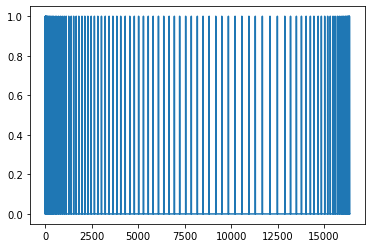

In [34]:
plt.figure()
plt.plot(deltar.numpy().flatten())